## Importing Libraries

In [43]:
import re
import numpy as np
import string
from typing import List

from unidecode import unidecode

import datasets
from datasets import load_dataset

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses

## Loading Data

In [2]:
def load_data_splits():
    raw_train_dataset, test_dataset = load_dataset('maritaca-ai/imdb_pt', split=['train', 'test'])
    raw_train_dataset = raw_train_dataset.train_test_split(0.2)

    return raw_train_dataset['train'], raw_train_dataset['test'], test_dataset

In [3]:
train_dataset, validation_dataset, test_dataset = load_data_splits()

Found cached dataset imdb_pt (/home/codespace/.cache/huggingface/datasets/maritaca-ai___imdb_pt/plain_text/1.0.0/ffeeea85dfdf69a15638f37cdae931de451276b0fbc70c92f7cad159b96abb05)
100%|██████████| 2/2 [00:00<00:00, 12.54it/s]


## Data Processing

In [82]:
VOCAB_SIZE = 10000
MAX_TOKENS = 256
BATCH_SIZE = 32

class DataPipeline:
    def __init__(self) -> None:
        self.vectorizer_layer = layers.TextVectorization(
            max_tokens=VOCAB_SIZE,
            standardize=self.compose_corpus_tensor,
            split='whitespace',
            ngrams=None,
            output_mode='int',
            output_sequence_length=MAX_TOKENS,
            pad_to_max_tokens=True,
            encoding='utf-8',
        )

    def fit_transform(self, dataset: datasets.arrow_dataset.Dataset):
        ds = dataset.map(self.decode_text, batch_size=BATCH_SIZE)
        corpus_tensor = self.compose_corpus_tensor(ds['text'])
        self.vectorizer_layer.adapt(corpus_tensor, batch_size=BATCH_SIZE)
        return self.vectorizer_layer(ds['text']), np.array(ds['label'])

    def transform(self, dataset: datasets.arrow_dataset.Dataset):
        ds = dataset.map(self.decode_text, batch_size=BATCH_SIZE)
        corpus = ds['text']
        return self.vectorizer_layer(corpus), np.array(ds['label'])

    @staticmethod
    def decode_text(dataset_row):
        dataset_row['text'] = unidecode(dataset_row['text'])
        return dataset_row

    @staticmethod
    def standardize_text(input_data):
        lowercase = tf.strings.lower(input_data)
        standardized = tf.strings.regex_replace(
            lowercase, 
            '[%s]' % re.escape(string.punctuation),
            ''
        )
        return standardized

    @staticmethod
    def compose_corpus_tensor(corpus):
        corpus_tensor = tf.expand_dims(corpus, -1)
        return corpus_tensor

In [83]:
data_pipeline = DataPipeline()

train_data, train_labels = data_pipeline.fit_transform(train_dataset)
validation_data, validation_labels = data_pipeline.transform(validation_dataset)
test_data, test_labels = data_pipeline.transform(test_dataset)

Loading cached processed dataset at /home/codespace/.cache/huggingface/datasets/maritaca-ai___imdb_pt/plain_text/1.0.0/ffeeea85dfdf69a15638f37cdae931de451276b0fbc70c92f7cad159b96abb05/cache-635d2f929d5e367f.arrow
Loading cached processed dataset at /home/codespace/.cache/huggingface/datasets/maritaca-ai___imdb_pt/plain_text/1.0.0/ffeeea85dfdf69a15638f37cdae931de451276b0fbc70c92f7cad159b96abb05/cache-b67d12ea374471a5.arrow
Loading cached processed dataset at /home/codespace/.cache/huggingface/datasets/maritaca-ai___imdb_pt/plain_text/1.0.0/ffeeea85dfdf69a15638f37cdae931de451276b0fbc70c92f7cad159b96abb05/cache-641110a89ca5198b.arrow


## Model

In [84]:
EMBEDDING_DIM = 2

model = keras.Sequential([
  layers.Embedding(VOCAB_SIZE + 1, EMBEDDING_DIM, input_length=256),
  layers.Flatten(),
  layers.Dropout(rate=0.5),
  layers.Dense(5),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 256, 2)            20002     
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 5)                 2565      
                                                                 
 dense_13 (Dense)            (None, 1)                 6         
                                                                 
Total params: 22,573
Trainable params: 22,573
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.metrics.BinaryAccuracy(), tf.metrics.Precision(), tf.metrics.Recall()])

In [86]:
EPOCHS = 10

history = model.fit(train_data,
                    np.array(train_labels),
                    epochs=EPOCHS,
                    batch_size=100,
                    validation_data=(validation_data, validation_labels),
                    verbose=1)

Epoch 1/10
200/200 [==============================] - 2s 7ms/step - loss: 0.6928 - binary_accuracy: 0.5102 - precision_7: 0.5098 - recall_7: 0.4821 - val_loss: 0.6903 - val_binary_accuracy: 0.5500 - val_precision_7: 0.5559 - val_recall_7: 0.5312
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.6370 - binary_accuracy: 0.6626 - precision_7: 0.6494 - recall_7: 0.7041 - val_loss: 0.5329 - val_binary_accuracy: 0.7664 - val_precision_7: 0.7781 - val_recall_7: 0.7503
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.4421 - binary_accuracy: 0.8029 - precision_7: 0.7982 - recall_7: 0.8096 - val_loss: 0.3931 - val_binary_accuracy: 0.8330 - val_precision_7: 0.8384 - val_recall_7: 0.8281
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3517 - binary_accuracy: 0.8498 - precision_7: 0.8451 - recall_7: 0.8559 - val_loss: 0.3660 - val_binary_accuracy: 0.8390 - val_precision_7: 0.8864 - val_recall_7: 0.7805
Epoch 5/10
200/2

In [88]:
history_dict = history.history

: 

In [79]:
import matplotlib.pyplot as plt
def plot_accuracy(history, miny=None):
    acc = history.history['binary_accuracy']
    test_acc = history.history['val_binary_accuracy']
    epochs = range(len(acc))
    plt.plot(epochs, acc)
    plt.plot(epochs, test_acc)
    if miny:
        plt.ylim(miny, 1.0)
    plt.title('accuracy') 
    plt.xlabel('epoch')
    plt.figure()

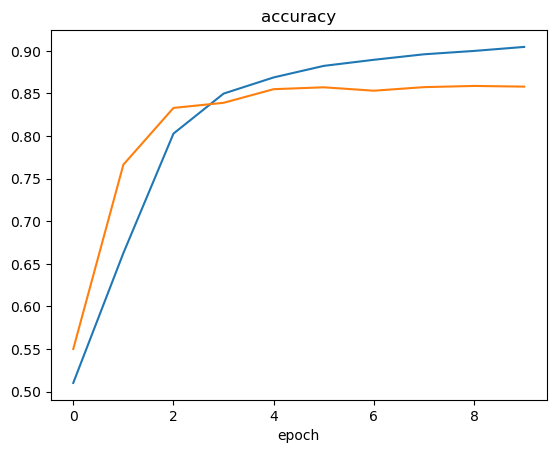

<Figure size 640x480 with 0 Axes>

In [87]:
plot_accuracy(history, miny=None)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)

history = model.fit(train_data,
                    np.array(train_labels),
                    epochs=EPOCHS,
                    batch_size=100,
                    validation_data=(validation_data, validation_labels),
                    callbacks=[callback]
                    verbose=1)
